# Credit Risk Scorecard - Production Model Export

This notebook extracts the trained model, preprocessing pipeline, and scorecard from the development notebook for production deployment.

## Objectives:
1. Load and process the loan data using the same preprocessing steps
2. Train the logistic regression model with WOE transformations
3. Export the complete pipeline (preprocessing + model) for production use
4. Generate the scorecard table for business interpretation
5. Validate model performance and create deployment artifacts


In [18]:
import warnings

import numpy as np
import pandas as pd
import joblib

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Silence warnings to keep output clean
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

## 1. Data Loading and Initial Setup


In [19]:
def load_data(filepath):
    """Load the loan dataset"""
    df = pd.read_csv(filepath)
    print(f"✅ Loaded dataset with {len(df)} rows and {len(df.columns)} columns")
    return df

# Load the data
df = load_data("../data/loan/loan.csv")


✅ Loaded dataset with 887379 rows and 74 columns


## 2. Preprocessing Pipeline Classes

We'll create custom transformers for each preprocessing step to make the pipeline reusable and exportable.


In [20]:
class TargetMapper(BaseEstimator, TransformerMixin):
    """Maps loan status to binary target variable"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        def map_loan_status(x):
            if x in ['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)', 
                     'Does not meet the credit policy. Status:Charged Off']:
                return 1   # BAD borrower
            elif x in ['Fully Paid', 'Current', 'Does not meet the credit policy. Status:Fully Paid']:
                return 0   # GOOD borrower
            else:
                return None  # Exclude these
        
        X['target'] = X['loan_status'].apply(map_loan_status)
        X = X.dropna(subset=['target'])  # Remove rows without a clear target
        X['target'] = X['target'].astype(int)
        
        # Keep the target column for later use
        return X

print("✅ TargetMapper class created")


✅ TargetMapper class created


In [21]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    """Drops columns that are non-predictive or contain data leakage"""
    
    def __init__(self):
        self.drop_cols = [
            'id', 'member_id', 'loan_status', 'url', 'desc', 'title', 'zip_code',
            'policy_code', 'next_pymnt_d', 'last_pymnt_d', 'last_credit_pull_d',
            'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'emp_title',
            'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
            'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
            'recoveries', 'collection_recovery_fee', 'mths_since_last_major_derog',
            # Additional columns with >95% missing values
            'il_util', 'mths_since_rcnt_il', 'total_bal_il', 'open_il_24m',
            'open_il_12m', 'open_acc_6m', 'open_rv_12m', 'open_rv_24m',
            'open_il_6m', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'max_bal_bc'
        ]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Only drop columns that exist in the dataframe
        cols_to_drop = [col for col in self.drop_cols if col in X.columns]
        X = X.drop(columns=cols_to_drop)
        return X

print("✅ ColumnDropper class created")


✅ ColumnDropper class created


In [22]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Engineers new features from existing ones"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Convert date columns and create credit history length
        X['issue_d'] = pd.to_datetime(X['issue_d'], format='%b-%Y', errors='coerce')
        X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], format='%b-%Y', errors='coerce')
        
        # Create credit history length (in years)
        X['credit_history_length'] = (X['issue_d'] - X['earliest_cr_line']).dt.days / 365
        
        # Drop date columns
        X = X.drop(columns=['issue_d', 'earliest_cr_line'])
        
        # Create loan burden ratio
        X['loan_burden'] = X['loan_amnt'] / (X['annual_inc'] + 1)
        
        # Drop original columns that are now redundant
        X = X.drop(columns=['loan_amnt', 'dti'])
        
        return X

print("✅ FeatureEngineer class created")


✅ FeatureEngineer class created


In [23]:
class MissingValueImputer(BaseEstimator, TransformerMixin):
    """Imputes missing values using median for numerical and mode for categorical"""

    def __init__(self):
        # Ensure all columns from file_context_0/impute_ok are included
        self.impute_columns = [
            'total_rev_hi_lim', 'tot_coll_amt', 'tot_cur_bal', 'emp_length',
            'revol_util', 'collections_12_mths_ex_med', 'acc_now_delinq',
            'total_acc', 'pub_rec', 'open_acc', 'inq_last_6mths',
            'delinq_2yrs', 'credit_history_length', 'annual_inc',
            'mths_since_last_record', 'mths_since_last_delinq',
            'loan_amnt', 'loan_burden'  # ensure loan_amnt is imputed!
        ]
        self.median_values = {}
        self.mode_values = {}

    def fit(self, X, y=None):
        X = X.copy()
        # Identify numerical and categorical columns
        numerical_cols = [col for col in self.impute_columns if col != 'emp_length' and col in X.columns]
        categorical_cols = [col for col in self.impute_columns if col == 'emp_length' and col in X.columns]

        # Fit numerical imputers
        for col in numerical_cols:
            if X[col].dropna().shape[0] > 0:
                self.median_values[col] = X[col].median()
            else:
                self.median_values[col] = 0  # fallback if all values are NaN

        # Fit categorical imputer
        for col in categorical_cols:
            if X[col].dropna().shape[0] > 0:
                self.mode_values[col] = X[col].mode(dropna=True)[0]
            else:
                self.mode_values[col] = "Unknown"  # fallback if all values are NaN

        return self

    def transform(self, X):
        X = X.copy()
        # Impute numerical columns
        for col, median_val in self.median_values.items():
            if col in X.columns:
                X[col] = X[col].fillna(median_val)
        # Impute categorical columns
        for col, mode_val in self.mode_values.items():
            if col in X.columns:
                X[col] = X[col].fillna(mode_val)
        return X

print("✅ MissingValueImputer class created")


✅ MissingValueImputer class created


In [24]:
class WOETransformer(BaseEstimator, TransformerMixin):
    """Applies Weight of Evidence (WOE) transformation to features"""
    
    def __init__(self, max_leaf_nodes=5):
        self.max_leaf_nodes = max_leaf_nodes
        self.features_to_bin = [
            'annual_inc', 'int_rate', 'credit_history_length', 'total_rev_hi_lim',
            'open_acc', 'revol_util', 'tot_cur_bal', 'mths_since_last_record', 
            'mths_since_last_delinq', 'loan_burden'
        ]
        self.categorical_features = [
            'term', 'home_ownership', 'purpose', 'emp_length', 'verification_status'
        ]
        self.final_woe_features = [
            'int_rate_woe', 'total_rev_hi_lim_woe', 'tot_cur_bal_woe',
            'annual_inc_woe', 'purpose_woe', 'loan_burden_woe',
            'credit_history_length_woe', 'revol_util_woe', 'verification_status_woe'
        ]
        self.bins = {}
        self.woe_mappings = {}
    
    def decision_tree_binning(self, X, y):
        """Create bins using decision tree"""
        X_reshaped = X.values.reshape(-1, 1)
        tree = DecisionTreeClassifier(
            criterion='entropy', 
            max_leaf_nodes=self.max_leaf_nodes, 
            min_samples_leaf=0.05
        )
        tree.fit(X_reshaped, y)
        
        thresholds = tree.tree_.threshold
        thresholds = thresholds[thresholds != -2]  # -2 = leaf node
        
        bins = [-np.inf] + sorted(thresholds.tolist()) + [np.inf]
        return bins
    
    def calc_woe_iv(self, df, feature_bin_col, target_col='target'):
        """Calculate WOE and IV for a feature"""
        grouped = df.groupby(feature_bin_col)[target_col].agg(['count', 'sum'])
        grouped.columns = ['total', 'bad']
        grouped['good'] = grouped['total'] - grouped['bad']
        
        dist_good = grouped['good'] / grouped['good'].sum()
        dist_bad = grouped['bad'] / grouped['bad'].sum()
        
        grouped['woe'] = np.log((dist_good + 1e-6) / (dist_bad + 1e-6))
        grouped['iv'] = (dist_good - dist_bad) * grouped['woe']
        
        woe_dict = grouped['woe'].to_dict()
        iv_score = grouped['iv'].sum()
        
        return woe_dict, iv_score
    
    def fit(self, X, y=None):
        X = X.copy()
        
        # If target is in X, extract it for WOE calculation
        if 'target' not in X.columns:
            print("Warning: Target column not found in X")
            return self
        
        target_col = X['target']
        
        # Bin numerical features
        for feature in self.features_to_bin:
            if feature in X.columns:
                try:
                    bins = self.decision_tree_binning(X[feature], target_col)
                    self.bins[feature] = bins
                    X[feature + '_bin'] = pd.cut(X[feature], bins=bins)
                except Exception as e:
                    print(f"Could not bin {feature}: {e}")
        
        # Calculate WOE for binned numerical features
        for feature in self.features_to_bin:
            bin_col = feature + '_bin'
            if bin_col in X.columns:
                try:
                    woe_map, iv_score = self.calc_woe_iv(X, bin_col, 'target')
                    self.woe_mappings[feature] = woe_map
                    print(f"✅ WOE calculated for {feature}, IV = {iv_score:.4f}")
                except Exception as e:
                    print(f"❌ Failed WOE calculation for {feature}: {e}")
        
        # Calculate WOE for categorical features
        for cat_feature in self.categorical_features:
            if cat_feature in X.columns:
                try:
                    woe_map, iv_score = self.calc_woe_iv(X, cat_feature, 'target')
                    self.woe_mappings[cat_feature] = woe_map
                    print(f"✅ WOE calculated for {cat_feature}, IV = {iv_score:.4f}")
                except Exception as e:
                    print(f"❌ Failed WOE calculation for {cat_feature}: {e}")
        
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Apply binning and WOE to numerical features
        for feature in self.features_to_bin:
            if feature in X.columns and feature in self.bins:
                X[feature + '_bin'] = pd.cut(X[feature], bins=self.bins[feature])
                if feature in self.woe_mappings:
                    X[feature + '_woe'] = X[feature + '_bin'].map(self.woe_mappings[feature])
        
        # Apply WOE to categorical features
        for cat_feature in self.categorical_features:
            if cat_feature in X.columns and cat_feature in self.woe_mappings:
                X[cat_feature + '_woe'] = X[cat_feature].map(self.woe_mappings[cat_feature])
        
        # Return all columns including target if it exists
        return X

print("✅ WOETransformer class created")


✅ WOETransformer class created


## 3. Build and Train the Complete Pipeline


In [25]:
# Create the complete preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('target_mapper', TargetMapper()),
    ('column_dropper', ColumnDropper()),
    ('feature_engineer', FeatureEngineer()),
    ('imputer', MissingValueImputer()),
    ('woe_transformer', WOETransformer())
])

print("✅ Preprocessing pipeline created")


✅ Preprocessing pipeline created


In [26]:
# Apply preprocessing pipeline using the fitted pipeline
print("🔄 Applying fitted preprocessing pipeline...")
df_processed = preprocessing_pipeline.fit_transform(df)

print(f"✅ Data processed. Shape: {df_processed.shape}")
print(f"Features after preprocessing: {list(df_processed.columns)}")

# Check for WOE features
woe_features = [col for col in df_processed.columns if col.endswith('_woe')]
print(f"\nWOE features created: {woe_features}")

if len(woe_features) == 0:
    print("❌ No WOE features found! Debugging the pipeline...")
    
    # Debug the WOE transformer in the pipeline
    woe_transformer = preprocessing_pipeline.named_steps['woe_transformer']
    print(f"WOE transformer bins: {list(woe_transformer.bins.keys())}")
    print(f"WOE transformer mappings: {list(woe_transformer.woe_mappings.keys())}")
    
    # Check what features were available during fitting
    print(f"Features to bin: {woe_transformer.features_to_bin}")
    print(f"Categorical features: {woe_transformer.categorical_features}")

# Check if target column exists
if 'target' in df_processed.columns:
    # Check class balance
    class_counts = df_processed['target'].value_counts()
    class_percent = df_processed['target'].value_counts(normalize=True) * 100

    balance_df = pd.DataFrame({
        'Count': class_counts,
        'Percentage': class_percent.round(2)
    }).rename(index={0: 'Good (0)', 1: 'Bad (1)'})

    print("\n📊 Class Balance:")
    print(balance_df)
else:
    print("❌ Target column not found in processed data")
    print("Available columns:", list(df_processed.columns))


🔄 Applying fitted preprocessing pipeline...
✅ WOE calculated for annual_inc, IV = 0.0539
✅ WOE calculated for int_rate, IV = 0.5026
✅ WOE calculated for credit_history_length, IV = 0.0447
✅ WOE calculated for total_rev_hi_lim, IV = 0.1483
✅ WOE calculated for open_acc, IV = 0.0052
✅ WOE calculated for revol_util, IV = 0.0353
✅ WOE calculated for tot_cur_bal, IV = 0.1340
✅ WOE calculated for mths_since_last_record, IV = 0.0111
✅ WOE calculated for mths_since_last_delinq, IV = 0.0023
✅ WOE calculated for loan_burden, IV = 0.0470
✅ WOE calculated for term, IV = 0.0212
✅ WOE calculated for home_ownership, IV = 0.0222
✅ WOE calculated for purpose, IV = 0.0497
✅ WOE calculated for emp_length, IV = 0.0067
✅ WOE calculated for verification_status, IV = 0.0352
✅ Data processed. Shape: (872666, 59)
Features after preprocessing: ['funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_pl

In [27]:
# Prepare features and target for modeling
desired_woe_features = [
    'int_rate_woe', 'total_rev_hi_lim_woe', 'tot_cur_bal_woe',
    'annual_inc_woe', 'purpose_woe', 'loan_burden_woe',
    'credit_history_length_woe', 'revol_util_woe', 'verification_status_woe'
]

# Get only the WOE features that actually exist
available_woe_features = [col for col in desired_woe_features if col in df_processed.columns]
print(f"Desired WOE features: {desired_woe_features}")
print(f"Available WOE features: {available_woe_features}")

if len(available_woe_features) == 0:
    print("❌ No WOE features available! Checking what columns exist...")
    print("All columns:", list(df_processed.columns))
    # Use all available features as fallback
    available_woe_features = [col for col in df_processed.columns if col.endswith('_woe')]
    print(f"Fallback WOE features: {available_woe_features}")

# Extract features and target
X = df_processed[available_woe_features]
y = df_processed['target']

print(f"✅ Features prepared. X shape: {X.shape}, y shape: {y.shape}")
print(f"Features used: {list(X.columns)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"✅ Data split. Train: {X_train.shape}, Test: {X_test.shape}")

# Update the final_woe_features for later use
final_woe_features = available_woe_features


Desired WOE features: ['int_rate_woe', 'total_rev_hi_lim_woe', 'tot_cur_bal_woe', 'annual_inc_woe', 'purpose_woe', 'loan_burden_woe', 'credit_history_length_woe', 'revol_util_woe', 'verification_status_woe']
Available WOE features: ['int_rate_woe', 'total_rev_hi_lim_woe', 'tot_cur_bal_woe', 'annual_inc_woe', 'purpose_woe', 'loan_burden_woe', 'credit_history_length_woe', 'revol_util_woe', 'verification_status_woe']
✅ Features prepared. X shape: (872666, 9), y shape: (872666,)
Features used: ['int_rate_woe', 'total_rev_hi_lim_woe', 'tot_cur_bal_woe', 'annual_inc_woe', 'purpose_woe', 'loan_burden_woe', 'credit_history_length_woe', 'revol_util_woe', 'verification_status_woe']
✅ Data split. Train: (610866, 9), Test: (261800, 9)


In [28]:
# Train the logistic regression model
print("🔄 Training logistic regression model...")
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

print("✅ Model trained successfully!")

# Display model coefficients
coefficients = model.coef_[0]
intercept = model.intercept_[0]

print("\n🔎 Model Coefficients:")
for feature, coef in zip(final_woe_features, coefficients):
    print(f"  {feature:<30} → {coef:.4f}")
print(f"  {'Intercept':<30} → {intercept:.4f}")


🔄 Training logistic regression model...
✅ Model trained successfully!

🔎 Model Coefficients:
  int_rate_woe                   → -0.9463
  total_rev_hi_lim_woe           → -0.2874
  tot_cur_bal_woe                → -0.7391
  annual_inc_woe                 → -0.3650
  purpose_woe                    → -0.3000
  loan_burden_woe                → -0.2106
  credit_history_length_woe      → -0.3059
  revol_util_woe                 → -0.2186
  verification_status_woe        → -0.3554
  Intercept                      → -2.5952


## 4. Model Evaluation


📊 Test AUC: 0.7188
📊 KS Statistic: 0.3280


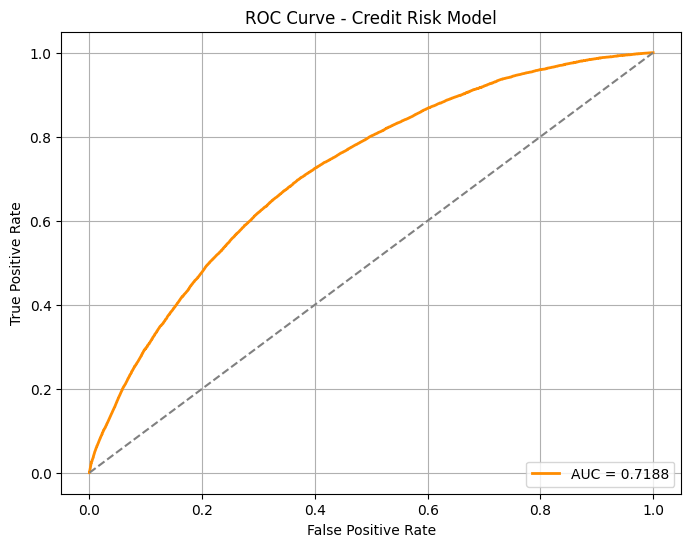


✅ Model evaluation completed!
   AUC Score: 0.7188
   KS Statistic: 0.3280


In [29]:
# Make predictions and evaluate
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Calculate AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"📊 Test AUC: {auc_score:.4f}")

# Calculate KS Statistic
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ks_statistic = max(tpr - fpr)
print(f"📊 KS Statistic: {ks_statistic:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve - Credit Risk Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"\n✅ Model evaluation completed!")
print(f"   AUC Score: {auc_score:.4f}")
print(f"   KS Statistic: {ks_statistic:.4f}")


## 5. Scorecard Generation


In [30]:
def generate_scorecard(df_processed, model, final_woe_features, woe_transformer):
    """Generate the scorecard table for business interpretation"""
    
    # Define Parameters for Score Scaling
    PDO = 20           # Points to Double the Odds
    BaseScore = 600    # Score assigned to base odds
    BaseOdds = 50      # Base odds = Good : Bad = 50:1
    
    Factor = PDO / np.log(2)  # scaling factor ≈ 28.85
    
    scorecard_rows = []
    
    for feature, coef in zip(final_woe_features, model.coef_[0]):
        base_feature = feature.replace('_woe', '')
        
        # Get the appropriate grouping column
        if base_feature + '_bin' in df_processed.columns:
            group_col = base_feature + '_bin'
        else:
            group_col = base_feature  # categorical feature
        
        try:
            # Calculate WOE for each bin
            grouped = df_processed.groupby(group_col)['target'].agg(['count', 'sum'])
            grouped.columns = ['total', 'bad']
            grouped['good'] = grouped['total'] - grouped['bad']
            
            dist_good = grouped['good'] / grouped['good'].sum()
            dist_bad = grouped['bad'] / grouped['bad'].sum()
            grouped['woe'] = np.log((dist_good + 1e-6) / (dist_bad + 1e-6))
            
            # Calculate points for each bin
            for bin_label, row in grouped.iterrows():
                woe = row['woe']
                points = -coef * woe * Factor
                
                scorecard_rows.append({
                    'feature': base_feature,
                    'bin': str(bin_label),
                    'woe': round(woe, 4),
                    'coefficient': round(coef, 4),
                    'points': round(points, 2)
                })
        
        except Exception as e:
            print(f"❌ Error processing {base_feature}: {e}")
    
    # Create scorecard DataFrame
    scorecard_df = pd.DataFrame(scorecard_rows).sort_values(by=['feature', 'bin'])
    
    return scorecard_df

# Generate the scorecard
print("🔄 Generating scorecard...")
scorecard = generate_scorecard(df_processed, model, final_woe_features, 
                              preprocessing_pipeline.named_steps['woe_transformer'])

print("✅ Scorecard generated successfully!")
print(f"Scorecard contains {len(scorecard)} rows")

# Display sample of scorecard
print("\n📋 Sample Scorecard:")
print(scorecard.head(10))


🔄 Generating scorecard...
✅ Scorecard generated successfully!
Scorecard contains 52 rows

📋 Sample Scorecard:
                  feature                    bin     woe  coefficient  points
15             annual_inc        (-inf, 43202.0] -0.2922      -0.3650   -3.08
19             annual_inc        (100129.0, inf]  0.3962      -0.3650    4.17
16             annual_inc     (43202.0, 66100.5] -0.0839      -0.3650   -0.88
17             annual_inc   (66100.5, 80046.219]  0.0909      -0.3650    0.96
18             annual_inc  (80046.219, 100129.0]  0.2157      -0.3650    2.27
39  credit_history_length          (-inf, 7.336] -0.4267      -0.3059   -3.77
41  credit_history_length       (13.593, 19.092]  0.0574      -0.3059    0.51
42  credit_history_length       (19.092, 24.768]  0.2339      -0.3059    2.06
43  credit_history_length          (24.768, inf]  0.3328      -0.3059    2.94
40  credit_history_length        (7.336, 13.593] -0.1416      -0.3059   -1.25


## 6. Model and Pipeline Export for Production


In [31]:
# Test the pipeline before exporting
print("🔄 Testing pipeline before export...")
test_sample = df.head(5).copy()

try:
    # Test the pipeline - use the same pipeline that was already fitted
    test_processed = preprocessing_pipeline.transform(test_sample)
    print(f"✅ Pipeline test successful! Processed shape: {test_processed.shape}")
    
    # Check if WOE features exist
    woe_features = [col for col in test_processed.columns if col.endswith('_woe')]
    print(f"WOE features in test: {woe_features}")
    
    if len(woe_features) == 0:
        print("❌ Warning: No WOE features found in test!")
        print("Available columns:", list(test_processed.columns))
        
        # Debug: Check if the WOE transformer was fitted properly
        woe_transformer = preprocessing_pipeline.named_steps['woe_transformer']
        print(f"WOE transformer bins: {list(woe_transformer.bins.keys())}")
        print(f"WOE transformer mappings: {list(woe_transformer.woe_mappings.keys())}")
    
except Exception as e:
    print(f"❌ Pipeline test failed: {e}")
    raise

# Create output directory for production artifacts
output_dir = Path("../models")
output_dir.mkdir(exist_ok=True)

print(f"📁 Output directory created: {output_dir.absolute()}")

# Export the complete preprocessing pipeline
pipeline_path = output_dir / "preprocessing_pipeline.joblib"
joblib.dump(preprocessing_pipeline, pipeline_path)
print(f"✅ Preprocessing pipeline exported to: {pipeline_path}")

# Export the trained model
model_path = output_dir / "credit_risk_model.joblib"
joblib.dump(model, model_path)
print(f"✅ Trained model exported to: {model_path}")

# Export the scorecard
scorecard_path = output_dir / "scorecard.csv"
scorecard.to_csv(scorecard_path, index=False)
print(f"✅ Scorecard exported to: {scorecard_path}")

# Export model metadata
metadata = {
    'model_type': 'LogisticRegression',
    'features': final_woe_features,
    'auc_score': float(auc_score),
    'ks_statistic': float(ks_statistic),
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'data_shape': {
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'features': len(final_woe_features)
    },
    'class_distribution': {
        'good_borrowers': int(class_counts[0]),
        'bad_borrowers': int(class_counts[1]),
        'good_percentage': float(class_percent[0]),
        'bad_percentage': float(class_percent[1])
    }
}

import json
metadata_path = output_dir / "model_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Model metadata exported to: {metadata_path}")

print(f"\n🎉 All production artifacts exported successfully!")
print(f"   📦 Pipeline: {pipeline_path}")
print(f"   🤖 Model: {model_path}")
print(f"   📊 Scorecard: {scorecard_path}")
print(f"   📋 Metadata: {metadata_path}")


🔄 Testing pipeline before export...
✅ Pipeline test successful! Processed shape: (5, 59)
WOE features in test: ['annual_inc_woe', 'int_rate_woe', 'credit_history_length_woe', 'total_rev_hi_lim_woe', 'open_acc_woe', 'revol_util_woe', 'tot_cur_bal_woe', 'mths_since_last_record_woe', 'mths_since_last_delinq_woe', 'loan_burden_woe', 'term_woe', 'home_ownership_woe', 'purpose_woe', 'emp_length_woe', 'verification_status_woe']
📁 Output directory created: d:\Credit Scorecard - Default Prediction\notebooks\..\models
✅ Preprocessing pipeline exported to: ..\models\preprocessing_pipeline.joblib
✅ Trained model exported to: ..\models\credit_risk_model.joblib
✅ Scorecard exported to: ..\models\scorecard.csv
✅ Model metadata exported to: ..\models\model_metadata.json

🎉 All production artifacts exported successfully!
   📦 Pipeline: ..\models\preprocessing_pipeline.joblib
   🤖 Model: ..\models\credit_risk_model.joblib
   📊 Scorecard: ..\models\scorecard.csv
   📋 Metadata: ..\models\model_metadata.js

## 7. Production Usage Example


In [32]:
# Example: How to use the exported pipeline and model in production

def predict_credit_risk(new_data, pipeline_path, model_path):
    """
    Example function showing how to use the exported pipeline and model
    for making predictions on new data in production.
    
    Args:
        new_data: DataFrame with raw loan application data
        pipeline_path: Path to the exported preprocessing pipeline
        model_path: Path to the exported trained model
    
    Returns:
        Dictionary with predictions and risk scores
    """
    
    try:
        # Load the pipeline and model
        pipeline = joblib.load(pipeline_path)
        model = joblib.load(model_path)
        
        # Apply preprocessing
        processed_data = pipeline.transform(new_data)
        
        # Extract features for prediction
        feature_columns = [
            'int_rate_woe', 'total_rev_hi_lim_woe', 'tot_cur_bal_woe',
            'annual_inc_woe', 'purpose_woe', 'loan_burden_woe',
            'credit_history_length_woe', 'revol_util_woe', 'verification_status_woe'
        ]
        
        # Only use columns that exist in the processed data
        available_features = [col for col in feature_columns if col in processed_data.columns]
        
        if len(available_features) == 0:
            raise ValueError(f"No features available for prediction. Available columns: {list(processed_data.columns)}")
        
        X_new = processed_data[available_features]
        
        # Check if X_new is empty
        if X_new.shape[0] == 0:
            raise ValueError("No samples to predict")
        
        # Make predictions
        probabilities = model.predict_proba(X_new)[:, 1]
        predictions = model.predict(X_new)
        
        # Calculate credit scores
        PDO = 20
        BaseScore = 600
        BaseOdds = 50
        Factor = PDO / np.log(2)
        Offset = BaseScore - Factor * np.log(BaseOdds)
        
        log_odds = model.intercept_ + np.dot(X_new, model.coef_.T).reshape(-1)
        scores = Offset - Factor * log_odds
        
        return {
            'probabilities': probabilities,
            'predictions': predictions,
            'scores': scores,
            'risk_level': ['High Risk' if p > 0.3 else 'Medium Risk' if p > 0.1 else 'Low Risk' 
                          for p in probabilities]
        }
        
    except Exception as e:
        print(f"Error in predict_credit_risk: {e}")
        raise

print("✅ Production prediction function created!")
print("This function demonstrates how to:")
print("  1. Load the exported pipeline and model")
print("  2. Preprocess new data using the same transformations")
print("  3. Make predictions and calculate credit scores")
print("  4. Return interpretable risk levels")


✅ Production prediction function created!
This function demonstrates how to:
  1. Load the exported pipeline and model
  2. Preprocess new data using the same transformations
  3. Make predictions and calculate credit scores
  4. Return interpretable risk levels


## 8. Model Validation and Testing


In [33]:
# Test the exported pipeline and model
print("🔄 Testing exported pipeline and model...")

# Take a small sample for testing
test_sample = df.head(10).copy()

try:
    # Load the pipeline and model directly to test
    print("Loading pipeline and model...")
    pipeline = joblib.load(pipeline_path)
    model = joblib.load(model_path)
    
    print("Applying preprocessing...")
    processed_data = pipeline.transform(test_sample)
    print(f"Processed data shape: {processed_data.shape}")
    print(f"Processed data columns: {list(processed_data.columns)}")
    
    # Extract features for prediction
    feature_columns = [
        'int_rate_woe', 'total_rev_hi_lim_woe', 'tot_cur_bal_woe',
        'annual_inc_woe', 'purpose_woe', 'loan_burden_woe',
        'credit_history_length_woe', 'revol_util_woe', 'verification_status_woe'
    ]
    
    # Only use columns that exist in the processed data
    available_features = [col for col in feature_columns if col in processed_data.columns]
    print(f"Available features for prediction: {available_features}")
    
    if len(available_features) == 0:
        print("❌ No features available for prediction!")
        print("All processed columns:", list(processed_data.columns))
        raise ValueError("No features available for prediction")
    
    X_new = processed_data[available_features]
    print(f"Feature matrix shape: {X_new.shape}")
    
    # Make predictions
    print("Making predictions...")
    probabilities = model.predict_proba(X_new)[:, 1]
    predictions = model.predict(X_new)
    
    # Calculate credit scores
    PDO = 20
    BaseScore = 600
    BaseOdds = 50
    Factor = PDO / np.log(2)
    Offset = BaseScore - Factor * np.log(BaseOdds)
    
    log_odds = model.intercept_ + np.dot(X_new, model.coef_.T).reshape(-1)
    scores = Offset - Factor * log_odds
    
    results = {
        'probabilities': probabilities,
        'predictions': predictions,
        'scores': scores,
        'risk_level': ['High Risk' if p > 0.3 else 'Medium Risk' if p > 0.1 else 'Low Risk' 
                      for p in probabilities]
    }
    
    print("✅ Pipeline and model test successful!")
    print(f"   Processed {len(test_sample)} samples")
    print(f"   Generated {len(results['scores'])} predictions")
    
    # Display sample results
    test_results = pd.DataFrame({
        'sample_id': range(len(test_sample)),
        'probability': results['probabilities'],
        'prediction': results['predictions'],
        'credit_score': results['scores'],
        'risk_level': results['risk_level']
    })
    
    print("\n📊 Sample Test Results:")
    print(test_results.head())
    
except Exception as e:
    print(f"❌ Test failed: {e}")
    import traceback
    traceback.print_exc()

# Validate model performance consistency
print(f"\n🔍 Model Performance Validation:")
print(f"   Original AUC: {auc_score:.4f}")
print(f"   Original KS: {ks_statistic:.4f}")

# Test feature importance
feature_importance = pd.DataFrame({
    'feature': final_woe_features,
    'coefficient': abs(model.coef_[0]),
    'importance': abs(model.coef_[0]) / sum(abs(model.coef_[0]))
}).sort_values('importance', ascending=False)

print(f"\n📈 Top 5 Most Important Features:")
print(feature_importance.head())


🔄 Testing exported pipeline and model...
Loading pipeline and model...
Applying preprocessing...
Processed data shape: (10, 59)
Processed data columns: ['funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target', 'credit_history_length', 'loan_burden', 'annual_inc_bin', 'annual_inc_woe', 'int_rate_bin', 'int_rate_woe', 'credit_history_length_bin', 'credit_history_length_woe', 'total_rev_hi_lim_bin', 'total_rev_hi_lim_woe', 'open_acc_bin', 'open_acc_woe', 'revol_util_bin', 'revol_util_woe', 'tot_cur_bal_bin', 'tot_cur_bal_woe', 'mths_sin

## 9. Production Deployment Summary


In [37]:
print(f"\n📦 EXPORTED ARTIFACTS:")
print(f"   1. Preprocessing Pipeline: models/preprocessing_pipeline.joblib")
print(f"   2. Trained Model: models/credit_risk_model.joblib") 
print(f"   3. Scorecard Table: models/scorecard.csv")
print(f"   4. Model Metadata: models/model_metadata.json")

print(f"\n📊 MODEL PERFORMANCE:")
print(f"   • AUC Score: {auc_score:.4f}")
print(f"   • KS Statistic: {ks_statistic:.4f}")
print(f"   • Training Samples: {len(X_train):,}")
print(f"   • Test Samples: {len(X_test):,}")
print(f"   • Features Used: {len(final_woe_features)}")

print(f"\n🔧 FEATURES IN PRODUCTION MODEL:")
for i, feature in enumerate(final_woe_features, 1):
    print(f"   {i:2d}. {feature}")



📦 EXPORTED ARTIFACTS:
   1. Preprocessing Pipeline: models/preprocessing_pipeline.joblib
   2. Trained Model: models/credit_risk_model.joblib
   3. Scorecard Table: models/scorecard.csv
   4. Model Metadata: models/model_metadata.json

📊 MODEL PERFORMANCE:
   • AUC Score: 0.7188
   • KS Statistic: 0.3280
   • Training Samples: 610,866
   • Test Samples: 261,800
   • Features Used: 9

🔧 FEATURES IN PRODUCTION MODEL:
    1. int_rate_woe
    2. total_rev_hi_lim_woe
    3. tot_cur_bal_woe
    4. annual_inc_woe
    5. purpose_woe
    6. loan_burden_woe
    7. credit_history_length_woe
    8. revol_util_woe
    9. verification_status_woe
